In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # 新增：可视化库
import seaborn as sns  # 新增：统计可视化库
sns.set(style="whitegrid", font_scale=1.2)  # 新增：设置可视化风格

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
!pip

In [ ]:

file_path = "BTC_USDT_1h.csv"
df = pd.read_csv(file_path)

In [ ]:
df.head(10)


,timestamp,datetime,open,high,low,close,volume
0,1704067200000,2024-01-01T00:00:00.000Z,42283.58,42554.57,42261.02,42475.23,1271.68108
1,1704070800000,2024-01-01T01:00:00.000Z,42475.23,42775.00,42431.65,42613.56,1196.37856
2,1704074400000,2024-01-01T02:00:00.000Z,42613.57,42638.41,42500.00,42581.10,685.21980
3,1704078000000,2024-01-01T03:00:00.000Z,42581.09,42586.64,42230.08,42330.49,794.80391
4,1704081600000,2024-01-01T04:00:00.000Z,42330.50,42399.99,42209.46,42399.99,715.41760
5,1704085200000,2024-01-01T05:00:00.000Z,42399.98,42406.00,42180.77,42234.01,736.53152
6,1704088800000,2024-01-01T06:00:00.000Z,42234.01,42424.82,42208.68,42396.69,601.37250
7,1704092400000,2024-01-01T07:00:00.000Z,42396.69,42500.00,42396.68,42492.46,653.67718
8,1704096000000,2024-01-01T08:00:00.000Z,42492.46,42556.50,42452.58,42549.99,427.19365
9,1704099600000,2024-01-01T09:00:00.000Z,42550.00,42699.32,42537.18,42649.69,879.62491


In [ ]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('datetime', inplace=True)


In [ ]:
# 特征工程
# 价格波动范围
df['price_range'] = df['high'] - df['low']

# 涨跌幅（百分比变化）
df['price_change_pct'] = df['close'].pct_change() * 100

# 简单移动平均（4小时窗口）
df['sma_4'] = df['close'].rolling(window=4).mean()

# 交易量变化
df['volume_change'] = df['volume'].pct_change()

# 时间特征
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['month'] = df.index.month
df['quarter'] = df.index.quarter

# 新增交易量相关特征
df['volume_sma_4'] = df['volume'].rolling(window=4).mean()
df['volume_std_4'] = df['volume'].rolling(window=4).std()
# ====================== 新增内容：高级时间特征 ======================
# 1. 周期性特征（正弦/余弦编码，增强时间序列周期性）
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # 新增：小时正弦编码
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)  # 新增：小时余弦编码
df['dayofweek_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)  # 新增：星期正弦编码
df['dayofweek_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)  # 新增：星期余弦编码

# 2. 交易日标识（区分周末/交易日，周末=0，交易日=1）
df['is_trading_day'] = np.where(df['day_of_week'].isin([5, 6]), 0, 1)  # 新增：周末标识

In [ ]:
# ====================== 新增内容：复杂技术指标 ======================
# 1. MACD指标（12, 26, 9）
close_price = df['close']
ema12 = close_price.rolling(window=12).mean()  # 新增：12期指数移动平均
ema26 = close_price.rolling(window=26).mean()  # 新增：26期指数移动平均
df['macd'] = ema12 - ema26  # 新增：MACD值
df['macd_signal'] = df['macd'].rolling(window=9).mean()  # 新增：MACD信号线
df['macd_diff'] = df['macd'] - df['macd_signal']  # 新增：MACD柱状图差值

# 2. 动量指标（14期动量）
n = 14
df['momentum'] = df['close'] / df['close'].shift(n) - 1  # 新增：动量特征
# ====================== 新增内容：特征交互 ======================
# 量价交叉特征（反映量价协同效应）
df['volatility_vol'] = df['price_range'] * df['volume']  # 新增：波动与交易量乘积
df['return_vol_corr'] = df['price_change_pct'].rolling(window=5).corr(df['volume_change'])  # 新增：收益与交易量相关性
# 处理特征中的NaN（由于rolling计算产生）
df.dropna(inplace=True)
# 存入新对象df_clean。删除包含NaN的行（确保所有特征有效）
df_clean = df.dropna().copy()  # 存入新对象df_clean

In [ ]:
df_clean.head(10)

,timestamp,open,high,low,close,volume,price_range,price_change_pct,sma_4,volume_change,...,hour_cos,dayofweek_sin,dayofweek_cos,is_trading_day,macd,macd_signal,macd_diff,momentum,volatility_vol,return_vol_corr
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-02 09:00:00,1704186000000,45759.30,45879.63,45631.10,45673.48,2096.46195,248.53,-0.187547,45514.2650,-0.369147,...,-7.071068e-01,0.781831,0.62349,1,1159.286154,909.359046,249.927108,0.049531,5.210337e+05,0.750565
2024-01-02 10:00:00,1704189600000,45673.48,45711.10,45431.52,45584.99,2069.22249,279.58,-0.193745,45618.3250,-0.012993,...,-8.660254e-01,0.781831,0.62349,1,1213.810385,983.952934,229.857450,0.043425,5.785132e+05,0.699972
2024-01-02 11:00:00,1704193200000,45585.00,45698.67,45200.00,45433.99,2538.49307,498.67,-0.331249,45612.9400,0.226786,...,-9.659258e-01,0.781831,0.62349,1,1211.258590,1045.054615,166.203974,0.041605,1.265870e+06,0.583720
2024-01-02 12:00:00,1704196800000,45433.99,45589.68,45271.04,45301.99,2128.11147,318.64,-0.290531,45498.6125,-0.161663,...,-1.000000e+00,0.781831,0.62349,1,1131.338910,1084.941311,46.397600,0.040709,6.781014e+05,0.191126
2024-01-02 13:00:00,1704200400000,45302.00,45705.80,45264.39,45637.93,2253.76868,441.41,0.741557,45489.7250,0.059046,...,-9.659258e-01,0.781831,0.62349,1,1083.128846,1107.848647,-24.719801,0.033010,9.948360e+05,0.182470
2024-01-02 14:00:00,1704204000000,45637.92,45800.00,44970.00,45258.73,4553.21243,830.00,-0.830888,45408.1600,1.020266,...,-8.660254e-01,0.781831,0.62349,1,972.711603,1108.747942,-136.036339,0.004500,3.779166e+06,-0.586982
2024-01-02 15:00:00,1704207600000,45258.73,45349.98,44833.33,45184.82,4301.03657,516.65,-0.163306,45345.8675,-0.055384,...,-7.071068e-01,0.781831,0.62349,1,859.609295,1089.860306,-230.251011,0.007331,2.222131e+06,-0.586978
2024-01-02 16:00:00,1704211200000,45184.83,45399.84,44890.11,45357.84,3052.23783,509.73,0.382916,45359.8300,-0.290348,...,-5.000000e-01,0.781831,0.62349,1,768.845962,1056.714850,-287.868889,-0.000465,1.555817e+06,-0.658353
2024-01-02 17:00:00,1704214800000,45357.84,45382.08,44950.48,44966.15,2540.00308,431.60,-0.863555,45191.8850,-0.167823,...,-2.588190e-01,0.781831,0.62349,1,667.103077,1007.454758,-340.351681,-0.009608,1.096265e+06,-0.452258


In [ ]:
df_clean.isna().sum()

timestamp           0
open                0
high                0
low                 0
close               0
volume              0
price_range         0
price_change_pct    0
sma_4               0
volume_change       0
hour                0
day_of_week         0
month               0
quarter             0
volume_sma_4        0
volume_std_4        0
hour_sin            0
hour_cos            0
dayofweek_sin       0
dayofweek_cos       0
is_trading_day      0
macd                0
macd_signal         0
macd_diff           0
momentum            0
volatility_vol      0
return_vol_corr     0
dtype: int64

In [ ]:
df_clean = df_clean.reset_index()

In [ ]:
df_clean.head(5)

,datetime,timestamp,open,high,low,close,volume,price_range,price_change_pct,sma_4,...,hour_cos,dayofweek_sin,dayofweek_cos,is_trading_day,macd,macd_signal,macd_diff,momentum,volatility_vol,return_vol_corr
0,2024-01-02 09:00:00,1704186000000,45759.30,45879.63,45631.10,45673.48,2096.46195,248.53,-0.187547,45514.2650,...,-0.707107,0.781831,0.62349,1,1159.286154,909.359046,249.927108,0.049531,5.210337e+05,0.750565
1,2024-01-02 10:00:00,1704189600000,45673.48,45711.10,45431.52,45584.99,2069.22249,279.58,-0.193745,45618.3250,...,-0.866025,0.781831,0.62349,1,1213.810385,983.952934,229.857450,0.043425,5.785132e+05,0.699972
2,2024-01-02 11:00:00,1704193200000,45585.00,45698.67,45200.00,45433.99,2538.49307,498.67,-0.331249,45612.9400,...,-0.965926,0.781831,0.62349,1,1211.258590,1045.054615,166.203974,0.041605,1.265870e+06,0.583720
3,2024-01-02 12:00:00,1704196800000,45433.99,45589.68,45271.04,45301.99,2128.11147,318.64,-0.290531,45498.6125,...,-1.000000,0.781831,0.62349,1,1131.338910,1084.941311,46.397600,0.040709,6.781014e+05,0.191126
4,2024-01-02 13:00:00,1704200400000,45302.00,45705.80,45264.39,45637.93,2253.76868,441.41,0.741557,45489.7250,...,-0.965926,0.781831,0.62349,1,1083.128846,1107.848647,-24.719801,0.033010,9.948360e+05,0.182470


In [ ]:
df_clean['volume'].head(5)

0    2096.46195
1    2069.22249
2    2538.49307
3    2128.11147
4    2253.76868
Name: volume, dtype: float64

In [ ]:
df_clean['target'] = df_clean['volume'].shift(-1)

In [ ]:
df_clean.dropna(inplace=True)

In [ ]:
df_clean

,datetime,timestamp,open,high,low,close,volume,price_range,price_change_pct,sma_4,...,dayofweek_sin,dayofweek_cos,is_trading_day,macd,macd_signal,macd_diff,momentum,volatility_vol,return_vol_corr,target
0,2024-01-02 09:00:00,1704186000000,45759.30,45879.63,45631.10,45673.48,2096.46195,248.53,-0.187547,45514.2650,...,0.781831,0.623490,1,1159.286154,909.359046,249.927108,0.049531,5.210337e+05,0.750565,2069.22249
1,2024-01-02 10:00:00,1704189600000,45673.48,45711.10,45431.52,45584.99,2069.22249,279.58,-0.193745,45618.3250,...,0.781831,0.623490,1,1213.810385,983.952934,229.857450,0.043425,5.785132e+05,0.699972,2538.49307
2,2024-01-02 11:00:00,1704193200000,45585.00,45698.67,45200.00,45433.99,2538.49307,498.67,-0.331249,45612.9400,...,0.781831,0.623490,1,1211.258590,1045.054615,166.203974,0.041605,1.265870e+06,0.583720,2128.11147
3,2024-01-02 12:00:00,1704196800000,45433.99,45589.68,45271.04,45301.99,2128.11147,318.64,-0.290531,45498.6125,...,0.781831,0.623490,1,1131.338910,1084.941311,46.397600,0.040709,6.781014e+05,0.191126,2253.76868
4,2024-01-02 13:00:00,1704200400000,45302.00,45705.80,45264.39,45637.93,2253.76868,441.41,0.741557,45489.7250,...,0.781831,0.623490,1,1083.128846,1107.848647,-24.719801,0.033010,9.948360e+05,0.182470,4553.21243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10961,2025-04-03 02:00:00,1743645600000,83761.63,83894.91,83278.99,83768.01,1422.27146,615.92,0.007629,83318.3675,...,0.433884,-0.900969,1,128.016923,394.901567,-266.884644,-0.015073,8.760054e+05,-0.947270,638.13813
10962,2025-04-03 03:00:00,1743649200000,83768.00,83792.58,83349.65,83483.97,638.13813,442.93,-0.339079,83560.2875,...,0.433884,-0.900969,1,-80.817179,345.933077,-426.750256,-0.020323,2.826505e+05,0.141778,630.55266
10963,2025-04-03 04:00:00,1743652800000,83483.97,83735.85,83263.05,83558.80,630.55266,472.80,0.089634,83643.1000,...,0.433884,-0.900969,1,-328.570897,254.147970,-582.718868,-0.027003,2.981253e+05,0.316436,457.59497
10964,2025-04-03 05:00:00,1743656400000,83558.81,83709.48,83343.74,83343.75,457.59497,365.74,-0.257364,83538.6325,...,0.433884,-0.900969,1,-554.808333,130.403084,-685.211417,-0.039350,1.673608e+05,0.746385,568.50834


In [ ]:
#features = [col for col in df_clean.columns if col not in ['datetime', 'timestamp', 'volume', 'target']]

In [ ]:
手动筛选

In [ ]:
features = ['open',
 'high',
 'low',
 'close',
 'sma_4',
 'hour',
 'month',
 'dayofweek_sin',
'hour_cos',
 'return_vol_corr']

In [ ]:
features=['open',
 'high',
 'low',
 'close','volume'
    ]

In [ ]:
X = df_clean[features]
y = df_clean['target']

In [ ]:
X

,open,high,low,close,volume
0,45759.30,45879.63,45631.10,45673.48,2096.46195
1,45673.48,45711.10,45431.52,45584.99,2069.22249
2,45585.00,45698.67,45200.00,45433.99,2538.49307
3,45433.99,45589.68,45271.04,45301.99,2128.11147
4,45302.00,45705.80,45264.39,45637.93,2253.76868
...,...,...,...,...,...
10961,83761.63,83894.91,83278.99,83768.01,1422.27146
10962,83768.00,83792.58,83349.65,83483.97,638.13813
10963,83483.97,83735.85,83263.05,83558.80,630.55266
10964,83558.81,83709.48,83343.74,83343.75,457.59497


In [ ]:
y

0        2069.22249
1        2538.49307
2        2128.11147
3        2253.76868
4        4553.21243
            ...    
10961     638.13813
10962     630.55266
10963     457.59497
10964     568.50834
10965     774.52407
Name: target, Length: 10966, dtype: float64

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [ ]:
def custom_log_error(y_true, y_pred):
    return np.mean(np.abs(np.log(y_pred / y_true)))

In [ ]:
test_size = int(len(X) * 0.2)
X_train_val, X_test, y_train_val, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]

# 6. 时间序列专用K折交叉验证（防止未来数据泄漏）
tscv = TimeSeriesSplit(n_splits=5)  # 5折，验证集始终在训练集之后

# 7. 构建包含PCA的Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 标准化
    ('pca', PCA()),  # PCA降维（自动选择最优成分）
    ('lgbm', lgb.LGBMRegressor(objective='regression', random_state=42))
])

# 8. 定义超参数搜索空间（包含PCA参数）
param_grid = {
    'pca__n_components': [None,5],  # None表示保留所有成分
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__num_leaves': [31, 63, 127],
    'lgbm__max_depth': [-1, 15, 25],
    'lgbm__subsample': [0.8, 1.0],
    'lgbm__colsample_bytree': [0.8, 1.0]
}

# 9. 自定义评估指标并执行网格搜索
scoring = make_scorer(custom_log_error, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

# 10. 训练模型（在训练验证集上进行时序K折搜索）
grid_search.fit(X_train_val, y_train_val)

# 11. 获取最佳模型并预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 12. 计算最终测试集误差
test_error = custom_log_error(y_test, y_pred)
print(f"最终测试集平均绝对对数误差: {test_error:.6f}")

# 13. 输出最佳参数与PCA成分数
print("\n最佳超参数组合:")
print(grid_search.best_params_)

# 14. 查看PCA保留的成分数（若启用）
pca_components = best_model.named_steps['pca'].n_components_
print(f"\nPCA保留的成分数: {pca_components if pca_components is not None else '全部'}")






Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 8773, number of used features: 5
[LightGBM] [Info] Start training from score 1468.479756
最终测试集平均绝对对数误差: 0.455333

最佳超参数组合:
{'lgbm__colsample_bytree': 1.0, 'lgbm__learning_rate': 0.05, 'lgbm__max_depth': -1, 'lgbm__num_leaves': 31, 'lgbm__subsample': 0.8, 'pca__n_components': None}

PCA保留的成分数: 5


In [ ]:
print("\n---------------------- 各折验证集损失 ----------------------")
cv_results = grid_search.cv_results_

for fold in range(tscv.get_n_splits()):
    # 验证集损失（每个超参数组合在第fold折的分数）
    val_scores = cv_results[f'split{fold}_test_score']
    print(f"Fold {fold+1} 平均验证损失: {np.mean(np.abs(val_scores)):.4f}")

# 最佳模型的训练集损失（在整个训练验证集上计算）
best_model = grid_search.best_estimator_
y_train_val_pred = best_model.predict(X_train_val)
train_val_error = custom_log_error(y_train_val, y_train_val_pred)
print(f"\n最佳模型训练验证集损失: {train_val_error:.4f}")


---------------------- 各折验证集损失 ----------------------
Fold 1 平均验证损失: 0.5495
Fold 2 平均验证损失: 0.6091
Fold 3 平均验证损失: 0.5282
Fold 4 平均验证损失: 0.5312
Fold 5 平均验证损失: 0.5828

最佳模型训练验证集损失: 0.3910


In [ ]:
lgbm_model = best_model.named_steps['lgbm']
feature_importances = lgbm_model.feature_importances_
feature_names = X_train_val.columns.tolist() 

In [ ]:
sorted_indices = np.argsort(feature_importances)[::-1]
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

high: 681.0000
low: 656.0000
open: 602.0000
volume: 575.0000
close: 486.0000


In [ ]:
import joblib
import pickle

# ----------------------- 1. 保存最佳模型（含所有预处理和算法参数） -----------------------
# 保存整个Pipeline模型（包含StandardScaler、PCA、LightGBM的参数）
model_save_path = 'best_model.pkl'
joblib.dump(best_model, model_save_path)
print(f"模型已保存至: {model_save_path}")

# ----------------------- 2. 保存训练时使用的特征列表（至关重要！） -----------------------
selected_features = X_train_val.columns.tolist()  # 获取特征名称列表
features_save_path = 'selected_features.pkl'
with open(features_save_path, 'wb') as f:
    pickle.dump(selected_features, f)
print(f"特征列表已保存至: {features_save_path}")

# ----------------------- 3. 可选：保存最佳超参数（模型已包含，可选做记录） -----------------------
best_params = grid_search.best_params_
params_save_path = 'best_params.pkl'
with open(params_save_path, 'wb') as f:
    pickle.dump(best_params, f)
print(f"最佳超参数已保存至: {params_save_path}")

# ----------------------- 4. 可选：保存PCA最终保留的成分数（用于调试） -----------------------
pca_components = best_model.named_steps['pca'].n_components_
with open('pca_components.pkl', 'wb') as f:
    pickle.dump(pca_components, f)

模型已保存至: best_model.pkl
特征列表已保存至: selected_features.pkl
最佳超参数已保存至: best_params.pkl


In [ ]:
# ====================== 1. 加载预训练模型与特征列表 ======================
# 加载保存的Pipeline模型（包含StandardScaler+PCA+LightGBM）
model_load_path = "best_model.pkl"
best_model = joblib.load(model_load_path)

# 加载训练时使用的特征列表
features_load_path = "selected_features.pkl"
with open(features_load_path, "rb") as f:
    expected_features = pickle.load(f)



In [ ]:
best_model

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('lgbm',
                 LGBMRegressor(learning_rate=0.05, objective='regression',
                               random_state=42, subsample=0.8))])

In [ ]:
expected_features

['open', 'high', 'low', 'close', 'volume']

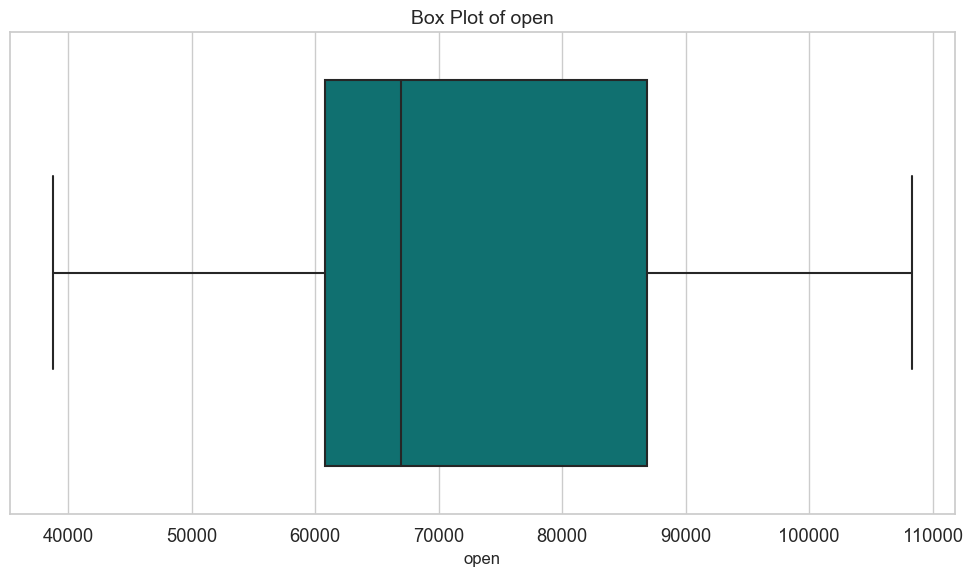

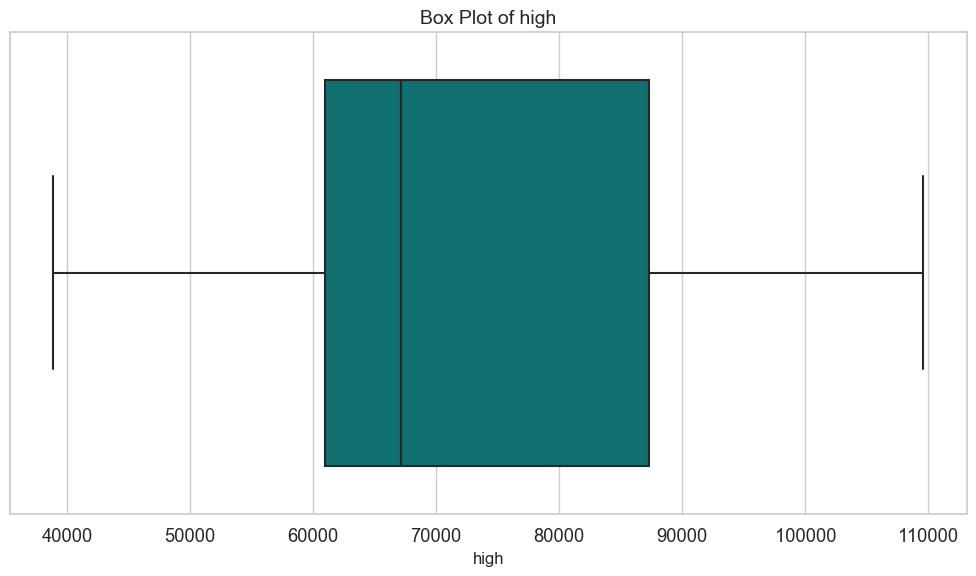

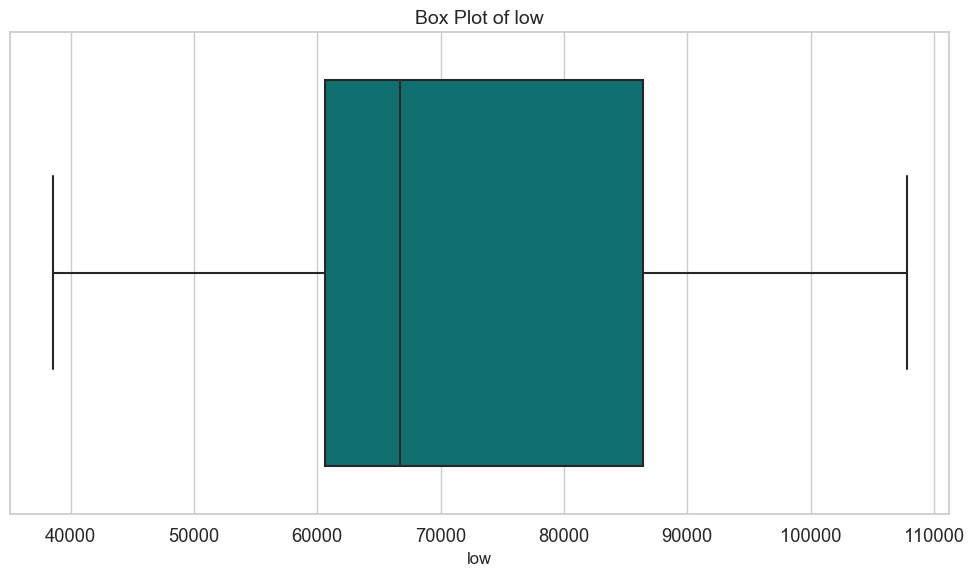

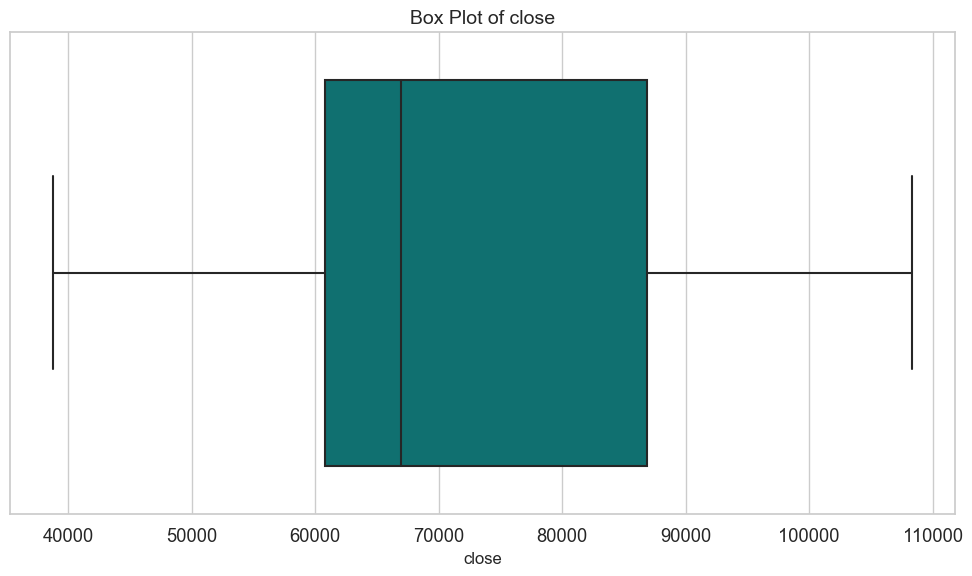

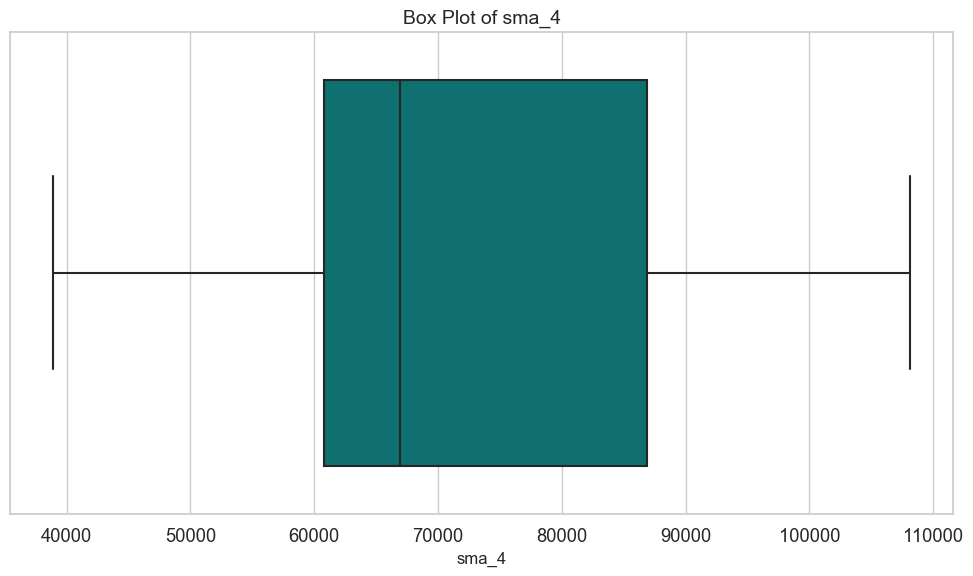

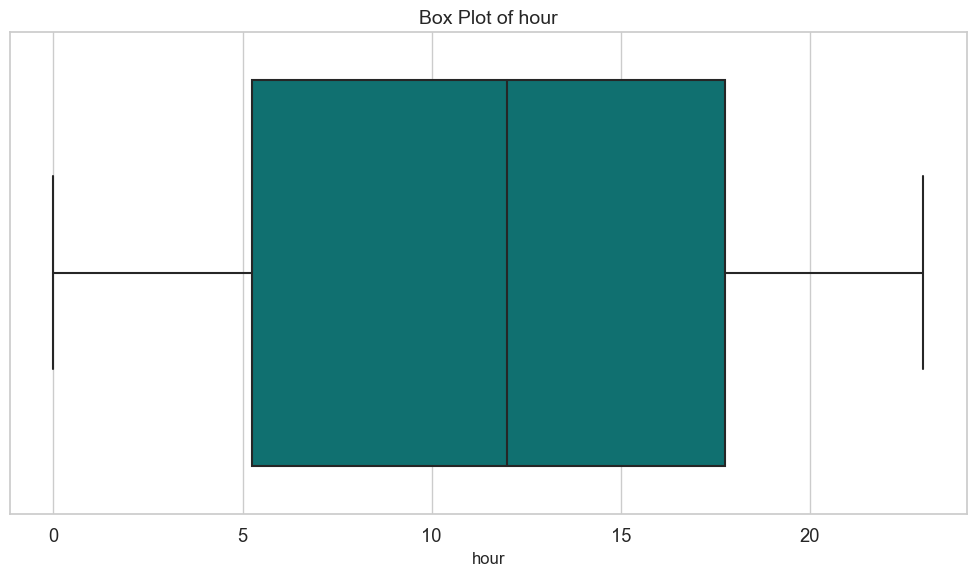

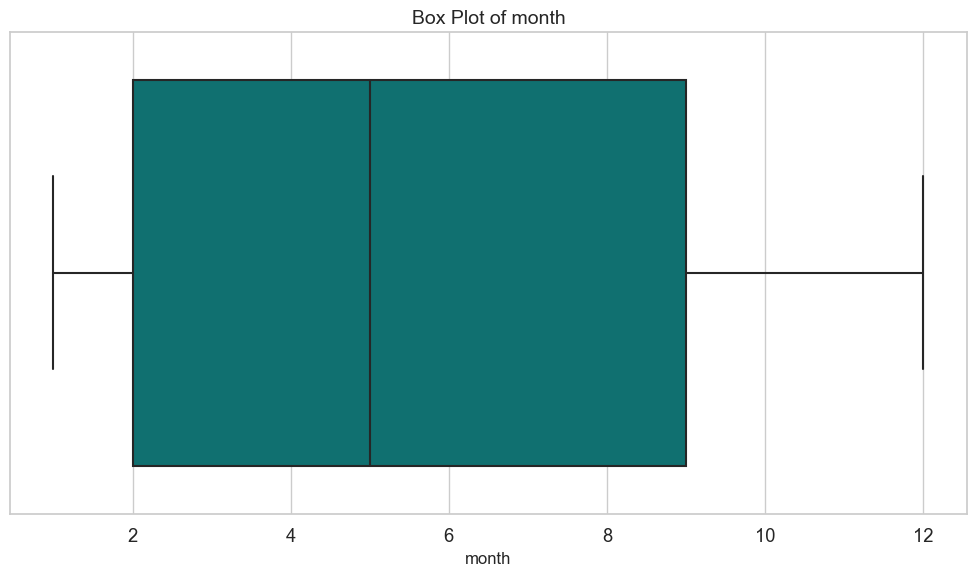

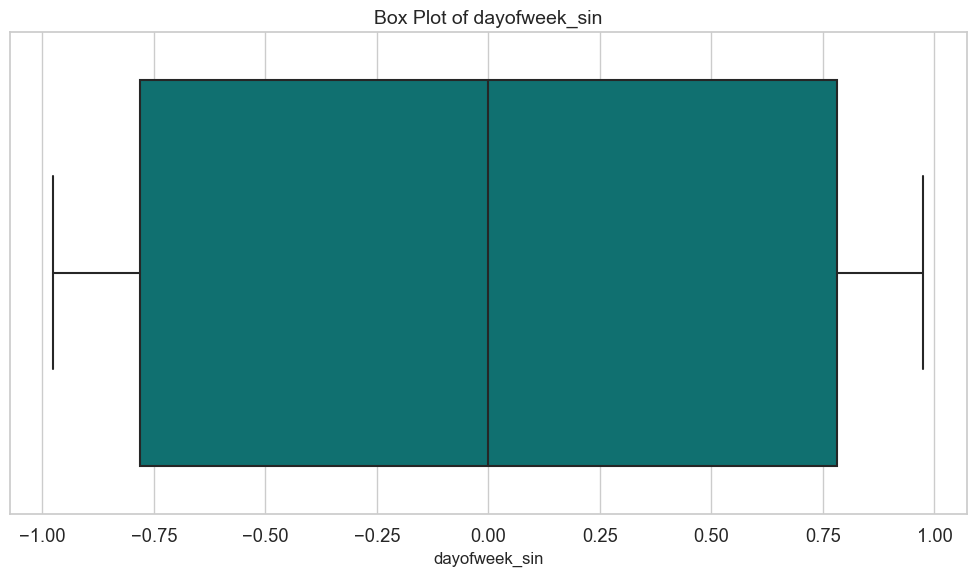

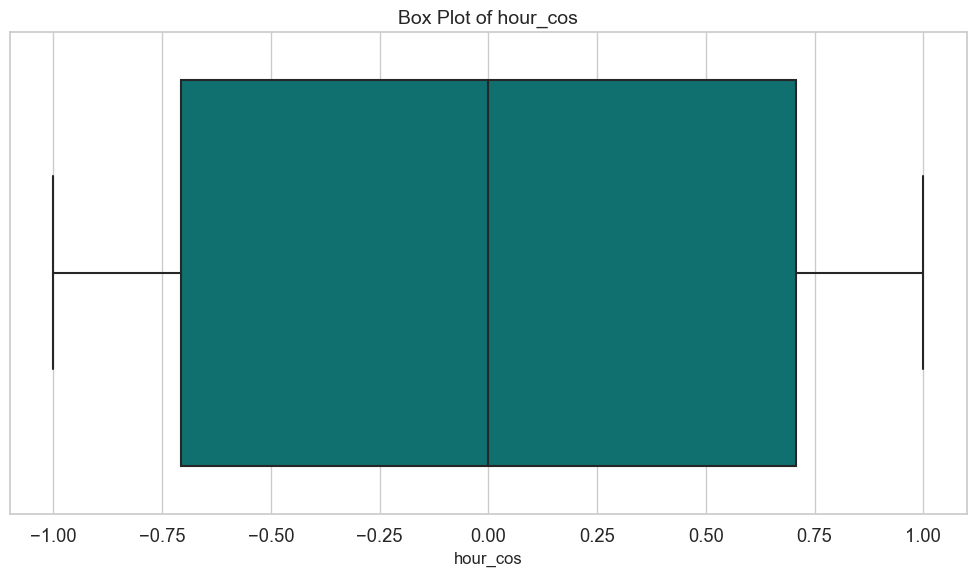

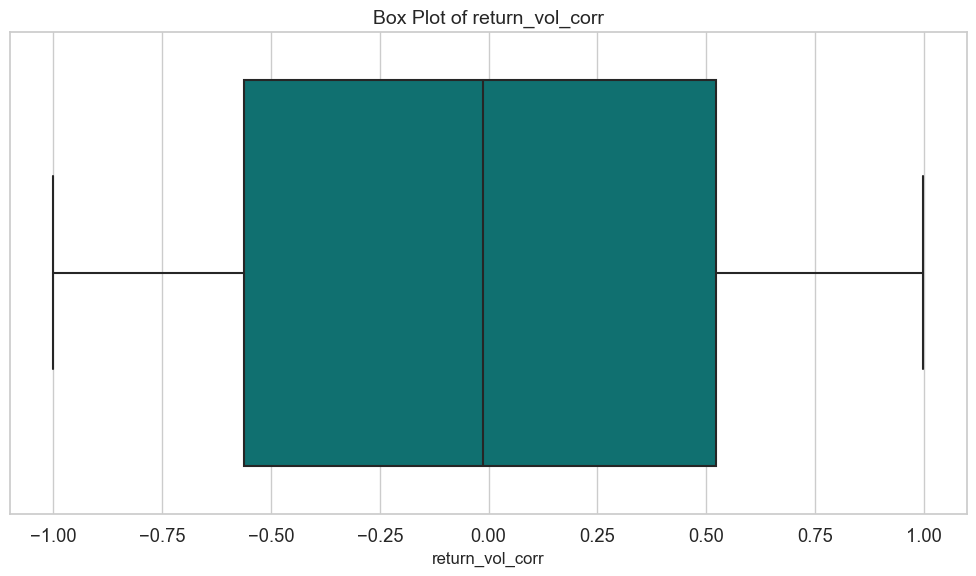

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 features 是特征列表，X 是包含这些特征的 DataFrame
features = X.columns.tolist()  # 获取特征列表

for col in features:
    plt.figure(figsize=(10, 6))  # 单个图的大小（更清晰）
    sns.boxplot(data=X, x=col, color="teal")
    plt.title(f"Box Plot of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.tight_layout()  # 自动调整布局
    plt.show()  # 显示当前图（阻塞，关闭后继续下一个）
    plt.close()  # 关闭当前图（可选，避免内存占用）

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

# 数据预处理
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# 检查平稳性
def check_stationarity(timeseries):
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return dftest[1] < 0.05

# 寻找最佳ARIMA参数
def find_best_arima_params(data, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_params = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = SARIMAX(data, order=(p,d,q), seasonal_order=(1,1,1,24))
                    results = model.fit(disp=False)
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p,d,q)
                except:
                    continue
    return best_params

# 检查收盘价的平稳性
print("检查收盘价的平稳性：")
is_stationary = check_stationarity(df['close'])

# 如果不平稳，进行差分
if not is_stationary:
    df['close_diff'] = df['close'].diff().dropna()
    print("\n检查差分后的平稳性：")
    check_stationarity(df['close_diff'])

# 寻找最佳ARIMA参数
print("\n寻找最佳ARIMA参数：")
best_params = find_best_arima_params(df['close'])
print(f"最佳参数 (p,d,q): {best_params}")

# 拟合SARIMA模型
model = SARIMAX(df['close'], 
                order=best_params,
                seasonal_order=(1,1,1,24))
results = model.fit(disp=False)

# 生成预测
forecast = results.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# 准备Prophet数据
prophet_df = df.reset_index()[['datetime', 'close']]
prophet_df.columns = ['ds', 'y']

# 初始化并拟合Prophet模型
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_df)

# 生成Prophet预测
future_dates = prophet_model.make_future_dataframe(periods=24, freq='H')
prophet_forecast = prophet_model.predict(future_dates)

# 合并特征
df['arima_pred'] = results.get_prediction(start=0).predicted_mean
df['arima_resid'] = results.resid
df['arima_forecast'] = forecast_mean
df['prophet_trend'] = prophet_forecast['trend'].values[:len(df)]
df['prophet_yearly'] = prophet_forecast['yearly'].values[:len(df)]
df['prophet_weekly'] = prophet_forecast['weekly'].values[:len(df)]
df['prophet_daily'] = prophet_forecast['daily'].values[:len(df)]

# 可视化结果
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df.index, df['close'], label='实际价格')
plt.plot(df.index, df['arima_pred'], label='ARIMA预测')
plt.title('ARIMA/SARIMA预测结果')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df.index, df['close'], label='实际价格')
plt.plot(df.index, df['prophet_trend'], label='Prophet趋势')
plt.title('Prophet趋势分析')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df.index, df['prophet_yearly'], label='年度季节性')
plt.plot(df.index, df['prophet_weekly'], label='周度季节性')
plt.title('Prophet季节性分析')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df.index, df['arima_resid'], label='ARIMA残差')
plt.title('ARIMA残差分析')
plt.legend()

plt.tight_layout()
plt.show()

# 保存预测结果
df.to_csv('time_series_predictions.csv')
print("\n预测结果已保存到 time_series_predictions.csv")